<a href="https://colab.research.google.com/github/ritikraj660/Speaker-recognition/blob/master/SR_SVM_MGFCC_1sec_overlapping_window.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#import os, signal
#os.kill(os.getpid(), signal.SIGKILL)

In [1]:
!pip install soundfile
!pip install spafe

     |████████████████████████████████| 81kB 3.9MB/s 


In [2]:
import tensorflow
tensorflow.test.gpu_device_name() 

'/device:GPU:0'

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
link = 'https://drive.google.com/file/d/1qxZWgx3vttou1HSvyxRDiOYWnaLAK9fj/view?usp=sharing'
#fluff, id = link.split('=')
id = '1qxZWgx3vttou1HSvyxRDiOYWnaLAK9fj'
print (id) 

1qxZWgx3vttou1HSvyxRDiOYWnaLAK9fj


In [0]:
import pandas as pd
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('LibriSpeech.zip')  

In [8]:
!pip install patool
import os
os.listdir()

     |████████████████████████████████| 81kB 3.9MB/s 


['.config', 'adc.json', 'LibriSpeech.zip', 'sample_data']

In [10]:
%%time
import patoolib
patoolib.extract_archive("LibriSpeech.zip")

patool: Extracting LibriSpeech.zip ...
patool: running /usr/bin/7z x -o./Unpack_f50kd703 -- LibriSpeech.zip
patool: ... LibriSpeech.zip extracted to `LibriSpeech1' (local file exists).
CPU times: user 11.2 ms, sys: 20.6 ms, total: 31.8 ms
Wall time: 556 ms


In [11]:
import librosa
import soundfile
import tqdm
from scipy.io import wavfile
import glob
import os,pickle
import numpy as np
from spafe.features.mfcc import mfcc, imfcc
import csv
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow.python.keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD

Using TensorFlow backend.


# New Section

In [0]:
from spafe.features.lpc import lpc
from spafe.features.gfcc import gfcc

def mfcc_(sig,fs,cep,frame_overlapp):
    mfccs  = mfcc(sig, fs=fs, num_ceps=cep, pre_emph=1, 
                  pre_emph_coeff=0.95,win_len=0.025, win_hop=frame_overlapp, win_type='hamming',
                  nfilts=26, nfft=512, low_freq=None, high_freq=None, scale='constant', 
                  dct_type=2, use_energy=False, lifter=22)
    #print(fs)
    return mfccs

def gfcc_(sig,fs,cep,frame_overlapp):
  gfccs = gfcc(sig, fs=fs, num_ceps=cep, pre_emph=0, 
             pre_emph_coeff=0.97, win_len=0.025, win_hop=frame_overlapp, win_type='hamming', 
             nfilts=26, nfft=512, low_freq=None, high_freq=None, scale='constant', 
             dct_type=2, use_energy=False, lifter=22, normalize=1)
  return gfccs

# combine mfcc and gfcc ceptral features
def gfcc_mfcc(y,sr,cep,frame_overlapp):
    g = gfcc_(y,sr,cep,frame_overlapp)
    m = mfcc_(y,sr,cep,frame_overlapp)
    if g.shape[0] != m.shape[0]:
        pass
    result = np.zeros([g.shape[1]+m.shape[1]])
    for i in range(g.shape[0]):
        merge = np.concatenate((m[i],g[i]))
        result = np.vstack((result,merge))
    return result[1:,:]

In [0]:
def label(user,total): # its creating lable for splited audio data
    k_train = []
    for i in range(total):
        k_train.append(user)
    y_train=np.array(k_train).T
    return y_train

In [0]:
def audioLengthInSecond(sr,m,t_s):#t_s will gives time in second[1 for 1sec, 2 for 2sec]
    t = round(sr/512) # Number of frames in one second
    totalFrame = t*t_s # Number of frames in one second * time(second)
    t1 = round(m.shape[0]/totalFrame) # total_audio_time/ t_s
    #print(time_in_sec)
    #print(" Actual audio length in second :",t1,"\n","Number of frames in one second :",t)
    j=0
    total = totalFrame*m.shape[1]
    result = np.zeros([1,total])
    #print(result.shape)
    for i in range(t1):
            temp = m[j:j+totalFrame,:].reshape(1,-1)
            diff = total-temp.shape[1]
            if round(total*0.3)>diff: # if more 30% padding need done then we will not add that audio file
                #print(diff)
                if diff!=0:
                    temp = np.concatenate((temp[0,:],temp[0,diff:diff+diff])).reshape(1,-1)
                #print("temp",temp.shape)
                result = np.concatenate((result,temp))
                j += totalFrame
            else:
                pass
    return result[1:,:]

In [0]:
from pathlib import Path
def s2c(mfcc=False,gmfcc=False,gfcc=False,cep=20,t_s=1, frame_overlapp = 0.01):
    x,y=[],[]
    if gmfcc==True:
      ceps=cep+cep
    else:
      ceps=cep
    t = round(16000/512)
    totalFrame = t*t_s
    total = totalFrame*ceps    
    data = np.empty([1,total])
    data_label = np.asarray([])
    count =0  # E:\dataset\LibriSpeech\dev-clean
    #for file in tqdm(glob.iglob('/LibriSpeech/test-clean//**/*.flac', recursive=True)):
    for file in Path('LibriSpeech/dev-clean').glob('**/*.flac'):
        file_name=os.path.basename(file)
        user = file_name.split("-")[0]
        #print(f)
        with soundfile.SoundFile(file) as sound_file:
                signal = sound_file.read(dtype="float32")
                sr=sound_file.samplerate
        #signal = norm_(signal,mean = False)
        #signal = zero_handling(signal)
        #print(signal.shape,sr)
        if mfcc:
            feature = mfcc_(signal,sr,cep,frame_overlapp)
            #print(feature.shape[0])
        if gmfcc:
            feature = gfcc_mfcc(signal,sr,cep,frame_overlapp)
            ceps = feature.shape[1]   
        #if feature.shape[0]>256:
        if gfcc:
            feature = gfcc_(signal,sr,cep,frame_overlapp)
        #t_s = 1
        re_data = audioLengthInSecond(sr,feature,t_s) # return (3,400)
        #print("shape of feature return ",re_data.shape)
        data=np.concatenate((data,re_data),axis=0)
        #print("Updated data length",data.shape)
        re_label = label(user,re_data.shape[0])
        data_label = np.concatenate((data_label,re_label),axis=0)
    return data[1:,:],data_label

In [0]:
def pre_pro(mfcc=False,gmfcc=True,gfcc=False,cep=20,dim=1,t_s=1,frame_overlapp = 0.01):
  
  x,y = s2c(mfcc=mfcc,gmfcc=gmfcc,gfcc=gfcc,cep=cep,t_s=t_s,frame_overlapp = frame_overlapp)
  #write_(x,y)
  print(x.shape,y.shape,type(x),type(y))
  if dim ==2:
    if gmfcc == True:
      ceps = cep+cep
    else:
      ceps = cep   
    d = np.empty([1,round(x.shape[1]/ceps),ceps])
    for i in tqdm(range(x.shape[0])):
      t = np.reshape(x[i],(1,-1,40))
      d = np.concatenate((d,t),axis=0)
    print(d.shape)
    x=d
  return x,y  

In [17]:
%%time
def x_y(mfcc=False,gmfcc=True,gfcc=False,cep=20,dim=1,t_s=2,frame_overlapp = 0.01):
  x,y = pre_pro(mfcc=False,gmfcc=True,gfcc=False,cep=20,dim=1,t_s=2,frame_overlapp = frame_overlapp)
  u = np.unique(y)
  num_classes = len(u)
  #print(u)
  d = dict()
  for enu,key in enumerate(u,0):
      d[key]=enu
  print(d)
  for i in range(len(y)):
      y[i] = d[y[i]]
  return x,y    

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 20.5 µs


# SVM

In [18]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas.util.testing as tm
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import accuracy_score
def svm_(mfcc=False,gmfcc=False,gfcc=False,cep=20,dim=1,t_s=1,frame_overlapp = 0.01):
  x,y = x_y(mfcc=mfcc,gmfcc=gmfcc,gfcc=gfcc,cep=cep,dim=1,t_s=t_s,frame_overlapp = frame_overlapp)
  x_train, x_test, y_train, y_test = train_test_split(x,y ,test_size=0.20, shuffle= True)

  print("Training shape: {0}, Training label shape : {1}".format(x_train.shape,y_train.shape))
  print("Training shape: {0}, Training label shape : {1}".format(x_test.shape,y_test.shape))

  print("Enteres into model moking")
  model = SVC(C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, 
                shrinking=True, probability=True, tol=0.001, cache_size=200, 
                class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr',
                break_ties=False, random_state=None)
  # fit model
  print("Entering into training Model")
  his = model.fit(x_train, y_train)
  # make predictions
  print("entering into predicting value")
  yhat = model.predict(x_test)
  acc = accuracy_score(y_test,yhat)
  print(acc)
  conf_mat = confusion_matrix(y_test, yhat)
  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(conf_mat, annot=True, fmt='d',
              xticklabels=[0,1,2,3,4,5,6,7,8,9], yticklabels=[0,1,2,3,4,5,6,7,8,9])
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
#svm_(mfcc=False,gmfcc=True,gfcc=False,cep=20,dim=1,t_s=1,frame_overlapp = 0.005)

In [20]:
cep_fea = ['mfcc','gfcc','gmfcc']
cep_num = [16,18,19,20,22]
time_ = [2,3,4,5]
win_over = [0.015,0.01,0.0075,0.005]
print(cep_fea,cep_num,time_,win_over)

['mfcc', 'gfcc', 'gmfcc'] [16, 18, 19, 20, 22] [2, 3, 4, 5] [0.015, 0.01, 0.0075, 0.005]


*****************************************************************************
***************time = 1 second, Cepstral feature= MFCC+GFCC, Frame Overlapping 0.015**********************
*****************************************************************************
(5093, 2480) (5093,) <class 'numpy.ndarray'> <class 'numpy.ndarray'>
{'1272': 0, '1462': 1, '1673': 2, '174': 3, '1919': 4, '251': 5, '422': 6, '652': 7, '777': 8, '84': 9}
Training shape: (4074, 2480), Training label shape : (4074,)
Training shape: (1019, 2480), Training label shape : (1019,)
Enteres into model moking
Entering into training Model
entering into predicting value
0.5839057899901865


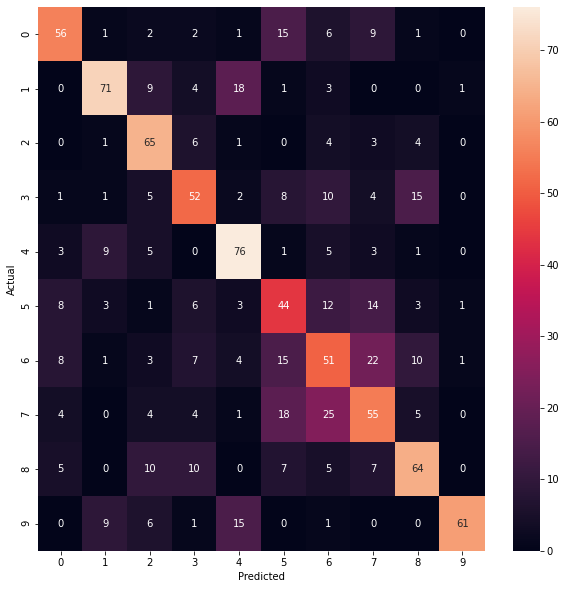

*****************************************************************************
*****************************************************************************
*****************************************************************************
***************time = 1 second, Cepstral feature= MFCC+GFCC, Frame Overlapping 0.01**********************
*****************************************************************************
(7704, 2480) (7704,) <class 'numpy.ndarray'> <class 'numpy.ndarray'>
{'1272': 0, '1462': 1, '1673': 2, '174': 3, '1919': 4, '251': 5, '422': 6, '652': 7, '777': 8, '84': 9}
Training shape: (6163, 2480), Training label shape : (6163,)
Training shape: (1541, 2480), Training label shape : (1541,)
Enteres into model moking
Entering into training Model
entering into predicting value
0.7650876054510058


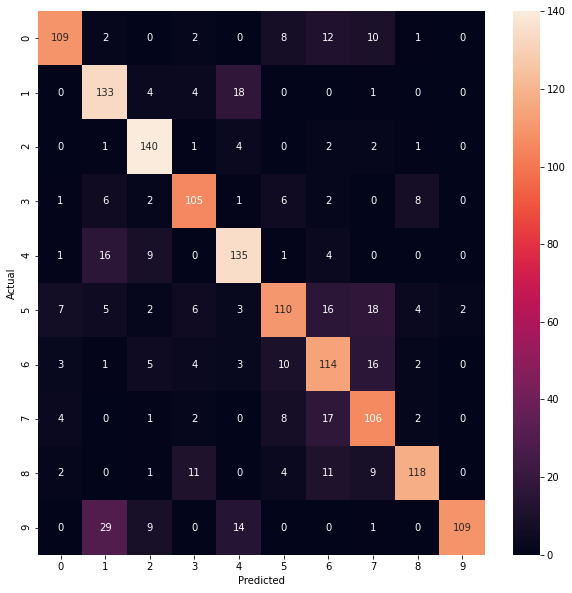

*****************************************************************************
*****************************************************************************
*****************************************************************************
***************time = 1 second, Cepstral feature= MFCC+GFCC, Frame Overlapping 0.0075**********************
*****************************************************************************
(10306, 2480) (10306,) <class 'numpy.ndarray'> <class 'numpy.ndarray'>
{'1272': 0, '1462': 1, '1673': 2, '174': 3, '1919': 4, '251': 5, '422': 6, '652': 7, '777': 8, '84': 9}
Training shape: (8244, 2480), Training label shape : (8244,)
Training shape: (2062, 2480), Training label shape : (2062,)
Enteres into model moking
Entering into training Model
entering into predicting value
0.8132880698351116


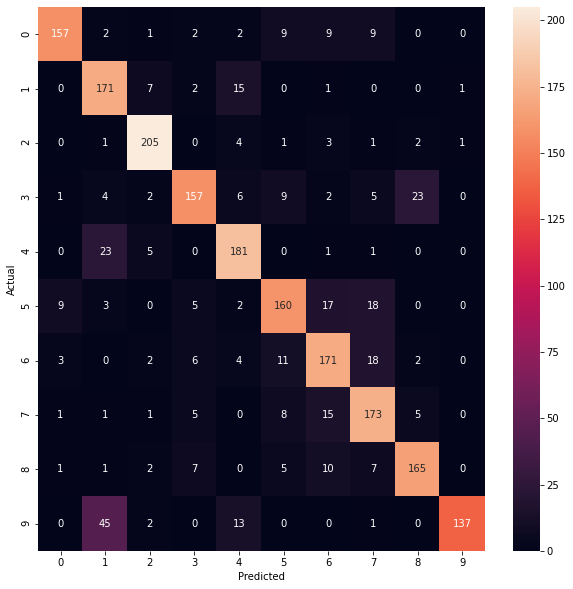

*****************************************************************************
*****************************************************************************
*****************************************************************************
***************time = 1 second, Cepstral feature= MFCC+GFCC, Frame Overlapping 0.005**********************
*****************************************************************************
(15540, 2480) (15540,) <class 'numpy.ndarray'> <class 'numpy.ndarray'>
{'1272': 0, '1462': 1, '1673': 2, '174': 3, '1919': 4, '251': 5, '422': 6, '652': 7, '777': 8, '84': 9}
Training shape: (12432, 2480), Training label shape : (12432,)
Training shape: (3108, 2480), Training label shape : (3108,)
Enteres into model moking
Entering into training Model
entering into predicting value
0.8761261261261262


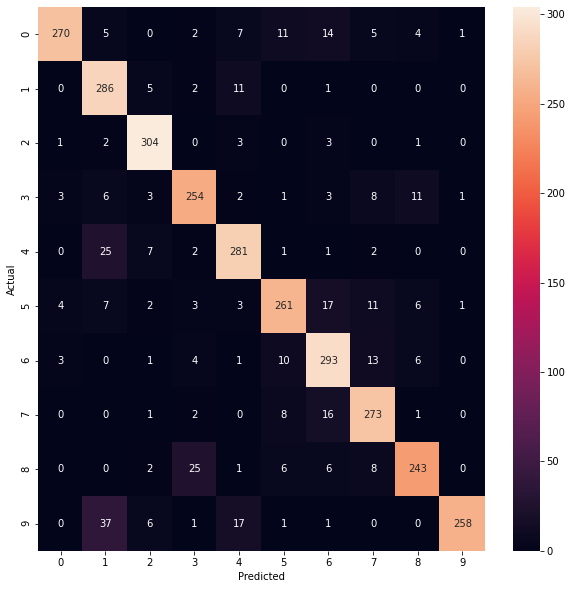

*****************************************************************************
*****************************************************************************


In [21]:
for i in win_over:
    print("*****************************************************************************")
    print("***************time = 1 second, Cepstral feature= MFCC+GFCC, Frame Overlapping {}**********************".format(i))
    print("*****************************************************************************")
    #if i == 0.01:
    svm_(mfcc=False,gmfcc=True,gfcc=False,cep=20,dim=1,t_s=1,frame_overlapp = i)
      #speaker(batch_sizes=16,epoch=200,mfcc=m,gmfcc=gm,gfcc=g,cep=20,dim=1,t_s=j,frame_overlapp = 0.01)
      #%%time
    print("*****************************************************************************")
    print("*****************************************************************************")

      